# EchoNet EF Prediction - Model Evaluation & Visualization

This notebook demonstrates the VideoMAE-based ejection fraction prediction model trained on the EchoNet-Dynamic dataset.

## 1. Setup & Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import sys
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm

# Add project root to path
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

from src.basic_model import EchoNetRegressor

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: /mnt/c/Users/thoma/Documents/cardio_demo_2
PyTorch version: 2.10.0+cu128
CUDA available: True


## 2. Load Data & Model

In [2]:
# Paths
CHECKPOINT_PATH = PROJECT_ROOT / "checkpoints" / "best_model.pt"
DATA_ROOT = PROJECT_ROOT / "EchoNet-Dynamic"
CSV_PATH = DATA_ROOT / "FileList.csv"
VIDEOS_DIR = DATA_ROOT / "Videos"

# Load metadata
df = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
df.head()

Total samples: 10030
Columns: ['FileName', 'EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS', 'NumberOfFrames', 'Split']


,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [3]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EchoNetRegressor(freeze_backbone=True)

if CHECKPOINT_PATH.exists():
    state_dict = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    print(f"Loaded checkpoint: {CHECKPOINT_PATH.name}")
else:
    print(f"Checkpoint not found: {CHECKPOINT_PATH}")

model.to(device)
model.eval()
print(f"Model on: {device}")

Loading VideoMAE Backbone: MCG-NJU/videomae-base


Loading weights:   0%|          | 0/184 [00:00<?, ?it/s]

VideoMAEModel LOAD REPORT from: MCG-NJU/videomae-base
Key                                                                  | Status     |  | 
---------------------------------------------------------------------+------------+--+-
decoder.decoder_layers.{0, 1, 2, 3}.intermediate.dense.bias          | UNEXPECTED |  | 
decoder.norm.bias                                                    | UNEXPECTED |  | 
decoder.decoder_layers.{0, 1, 2, 3}.attention.output.dense.bias      | UNEXPECTED |  | 
decoder.decoder_layers.{0, 1, 2, 3}.attention.output.dense.weight    | UNEXPECTED |  | 
decoder.decoder_layers.{0, 1, 2, 3}.attention.attention.query.weight | UNEXPECTED |  | 
decoder.decoder_layers.{0, 1, 2, 3}.attention.attention.v_bias       | UNEXPECTED |  | 
decoder.decoder_layers.{0, 1, 2, 3}.layernorm_after.weight           | UNEXPECTED |  | 
decoder.decoder_layers.{0, 1, 2, 3}.attention.attention.q_bias       | UNEXPECTED |  | 
decoder.decoder_layers.{0, 1, 2, 3}.output.dense.bias             

Freezing Backbone Weights...
Loaded checkpoint: best_model.pt
Model on: cuda


## 3. Dataset Exploration

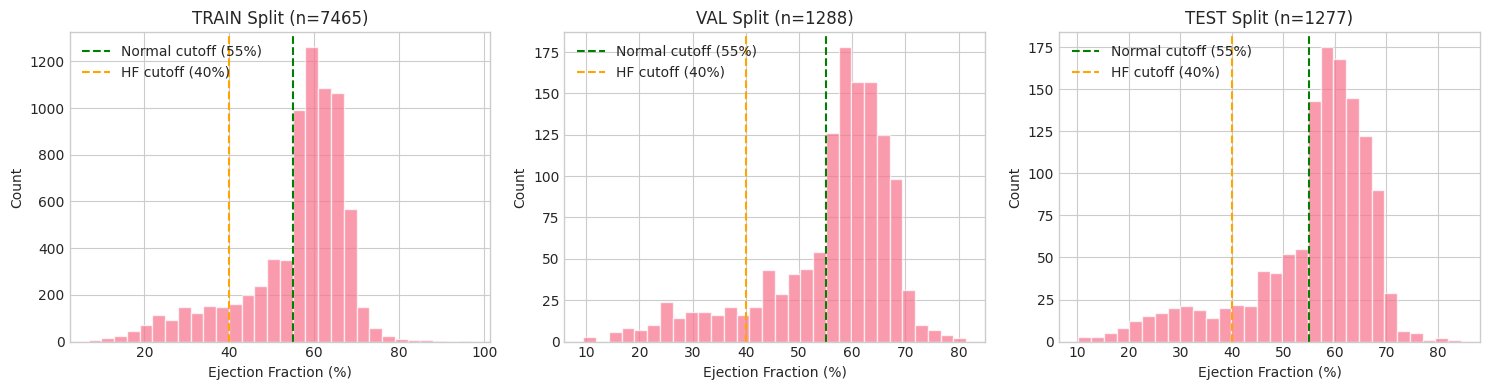

In [4]:
# EF Distribution by Split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, split in zip(axes, ['TRAIN', 'VAL', 'TEST']):
    split_df = df[df['Split'] == split]
    ax.hist(split_df['EF'], bins=30, edgecolor='white', alpha=0.7)
    ax.axvline(x=55, color='green', linestyle='--', label='Normal cutoff (55%)')
    ax.axvline(x=40, color='orange', linestyle='--', label='HF cutoff (40%)')
    ax.set_xlabel('Ejection Fraction (%)')
    ax.set_ylabel('Count')
    ax.set_title(f'{split} Split (n={len(split_df)})')
    ax.legend()

plt.tight_layout()
plt.show()

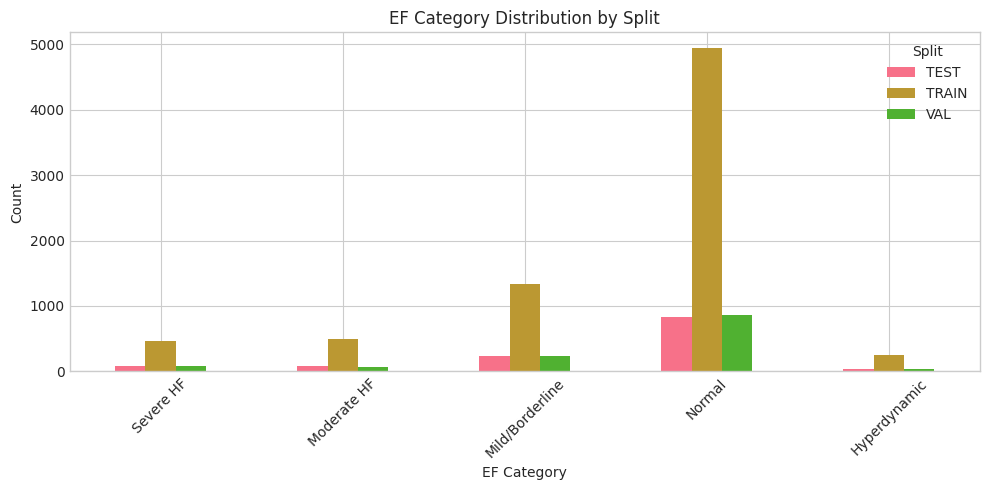

In [5]:
# Clinical Categories Distribution
def get_ef_category(ef):
    if ef < 30: return 'Severe HF'
    elif ef < 40: return 'Moderate HF'
    elif ef < 55: return 'Mild/Borderline'
    elif ef < 70: return 'Normal'
    else: return 'Hyperdynamic'

df['EF_Category'] = df['EF'].apply(get_ef_category)

category_order = ['Severe HF', 'Moderate HF', 'Mild/Borderline', 'Normal', 'Hyperdynamic']
cat_counts = df.groupby(['Split', 'EF_Category']).size().unstack(fill_value=0)[category_order]

cat_counts.T.plot(kind='bar', figsize=(10, 5))
plt.title('EF Category Distribution by Split')
plt.xlabel('EF Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Split')
plt.tight_layout()
plt.show()

## 4. Sample Video Frames

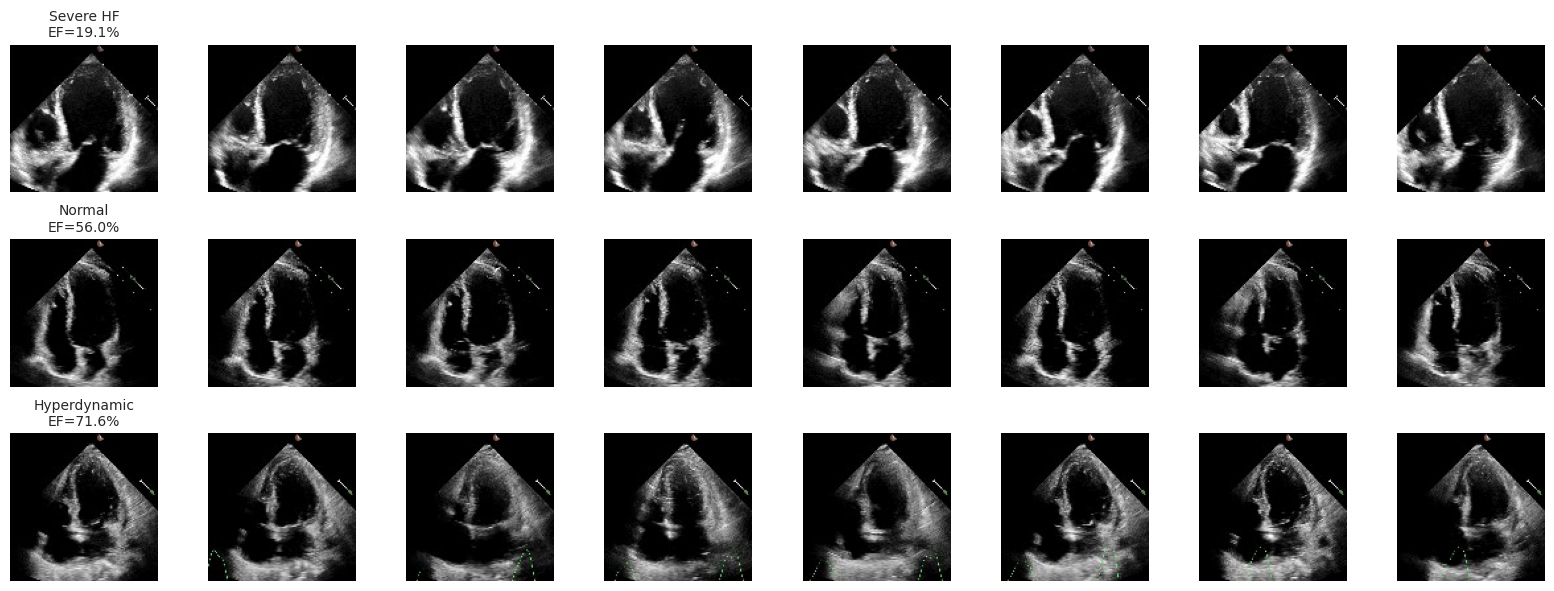

In [6]:
def extract_frames(video_path, num_frames=8):
    """Extract evenly-spaced frames from video."""
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames

# Show samples from different EF ranges
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

categories = ['Severe HF', 'Normal', 'Hyperdynamic']
for row, cat in enumerate(categories):
    sample = df[(df['EF_Category'] == cat) & (df['Split'] == 'TEST')].iloc[0]
    video_path = VIDEOS_DIR / (sample['FileName'] if sample['FileName'].endswith('.avi') else f"{sample['FileName']}.avi")
    if video_path.exists():
        frames = extract_frames(video_path, num_frames=8)
        for col, frame in enumerate(frames):
            axes[row, col].imshow(frame)
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_title(f"{cat}\nEF={sample['EF']:.1f}%", fontsize=10)

plt.tight_layout()
plt.show()

## 5. Run Inference on Test Set

In [7]:
# Preprocessing constants
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
NUM_FRAMES = 16
FRAME_SIZE = 224

def preprocess_video(video_path):
    """Load and preprocess video for model input."""
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, NUM_FRAMES, dtype=int)
    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (FRAME_SIZE, FRAME_SIZE))
            frames.append(frame)
    cap.release()
    if len(frames) < NUM_FRAMES:
        return None
    frames = np.array(frames, dtype=np.float32) / 255.0
    frames = (frames - IMAGENET_MEAN) / IMAGENET_STD
    frames = np.transpose(frames, (0, 3, 1, 2))
    tensor = torch.from_numpy(frames).unsqueeze(0).float()
    return tensor

In [8]:
# Run inference on test set
test_df = df[df['Split'] == 'TEST'].copy()
print(f"Running inference on {len(test_df)} test samples...")

predictions = []
true_values = []
filenames = []

with torch.no_grad():
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        video_path = VIDEOS_DIR / (row['FileName'] if row['FileName'].endswith('.avi') else f"{row['FileName']}.avi")
        if not video_path.exists():
            continue
        tensor = preprocess_video(video_path)
        if tensor is None:
            continue
        tensor = tensor.to(device)
        pred = model(tensor)
        pred_ef = max(0, min(100, pred.item()))
        predictions.append(pred_ef)
        true_values.append(row['EF'])
        filenames.append(row['FileName'])

predictions = np.array(predictions)
true_values = np.array(true_values)
print(f"Completed: {len(predictions)} predictions")

Running inference on 1277 test samples...


100%|████████████████████████████████████████████████████████████████| 1277/1277 [01:59<00:00, 10.65it/s]

Completed: 1277 predictions


## 6. Overall Metrics

In [9]:
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(np.mean((predictions - true_values) ** 2))
r2 = r2_score(true_values, predictions)
correlation = np.corrcoef(predictions, true_values)[0, 1]

print("=" * 50)
print("OVERALL TEST SET METRICS")
print("=" * 50)
print(f"Mean Absolute Error (MAE): {mae:.2f}%")
print(f"Root Mean Squared Error:   {rmse:.2f}%")
print(f"R² Score:                  {r2:.3f}")
print(f"Pearson Correlation:       {correlation:.3f}")
print("=" * 50)

OVERALL TEST SET METRICS
Mean Absolute Error (MAE): 6.93%
Root Mean Squared Error:   9.81%
R² Score:                  0.356
Pearson Correlation:       0.712


## 7. Per-Bin MAE Analysis

In [10]:
results_df = pd.DataFrame({
    'FileName': filenames,
    'True_EF': true_values,
    'Pred_EF': predictions,
    'Error': np.abs(predictions - true_values),
    'Category': [get_ef_category(ef) for ef in true_values]
})

bin_metrics = results_df.groupby('Category').agg({'Error': ['mean', 'std', 'count']}).round(2)
bin_metrics.columns = ['MAE', 'Std', 'Count']
bin_metrics = bin_metrics.reindex(category_order)
bin_metrics

,MAE,Std,Count
Category,,,
Severe HF,19.91,9.76,83
Moderate HF,19.74,7.28,77
Mild/Borderline,10.12,4.52,241
Normal,3.45,2.42,838
Hyperdynamic,9.30,3.58,38


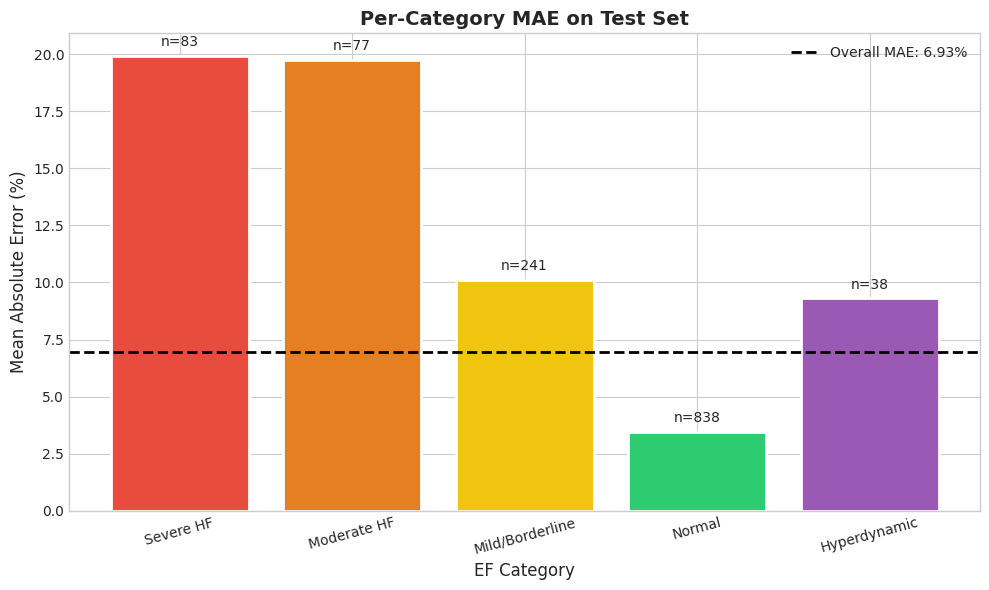

In [11]:
# Per-bin MAE bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#9b59b6']
bars = ax.bar(bin_metrics.index, bin_metrics['MAE'], color=colors, edgecolor='white', linewidth=2)
ax.axhline(y=mae, color='black', linestyle='--', linewidth=2, label=f'Overall MAE: {mae:.2f}%')
ax.set_xlabel('EF Category', fontsize=12)
ax.set_ylabel('Mean Absolute Error (%)', fontsize=12)
ax.set_title('Per-Category MAE on Test Set', fontsize=14, fontweight='bold')
ax.legend()
for bar, count in zip(bars, bin_metrics['Count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'n={int(count)}', ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 8. Prediction Scatter Plots

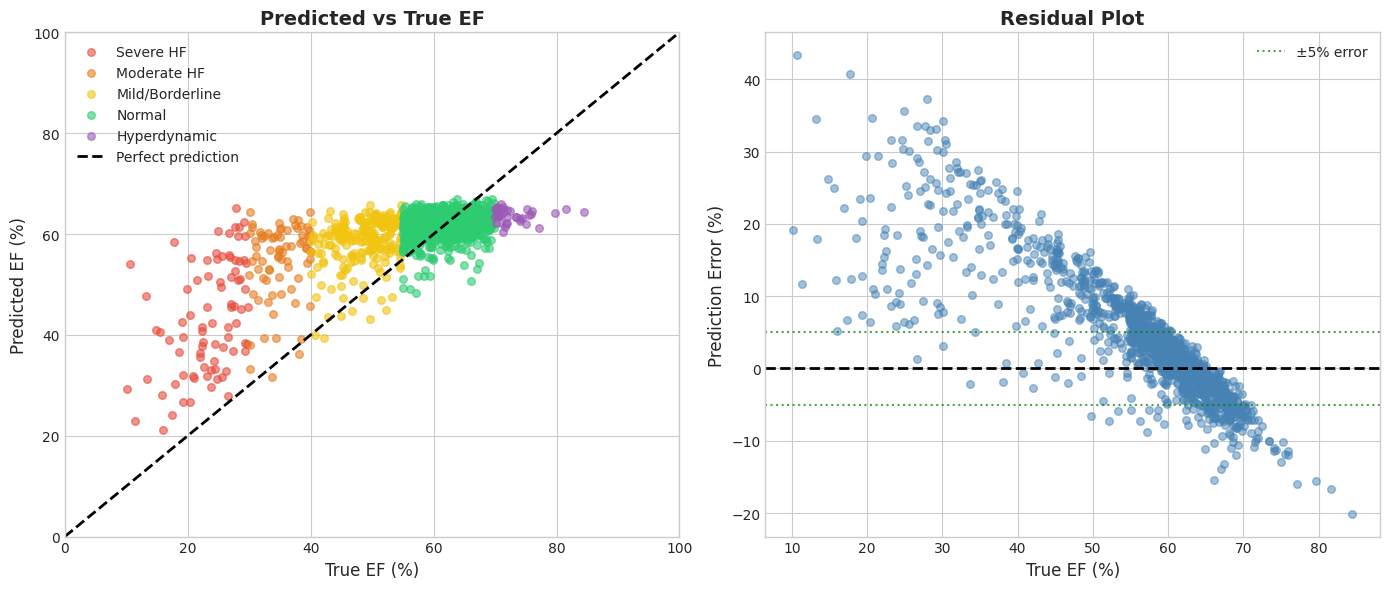

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

category_colors = {'Severe HF': '#e74c3c', 'Moderate HF': '#e67e22', 
                   'Mild/Borderline': '#f1c40f', 'Normal': '#2ecc71', 'Hyperdynamic': '#9b59b6'}

for cat in category_order:
    mask = results_df['Category'] == cat
    axes[0].scatter(results_df.loc[mask, 'True_EF'], results_df.loc[mask, 'Pred_EF'], 
                   c=category_colors[cat], label=cat, alpha=0.6, s=30)

axes[0].plot([0, 100], [0, 100], 'k--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True EF (%)', fontsize=12)
axes[0].set_ylabel('Predicted EF (%)', fontsize=12)
axes[0].set_title('Predicted vs True EF', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)

# Residual plot
residuals = predictions - true_values
axes[1].scatter(true_values, residuals, alpha=0.5, s=30, c='steelblue')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1].axhline(y=5, color='green', linestyle=':', alpha=0.7, label='±5% error')
axes[1].axhline(y=-5, color='green', linestyle=':', alpha=0.7)
axes[1].set_xlabel('True EF (%)', fontsize=12)
axes[1].set_ylabel('Prediction Error (%)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 9. Bland-Altman Plot

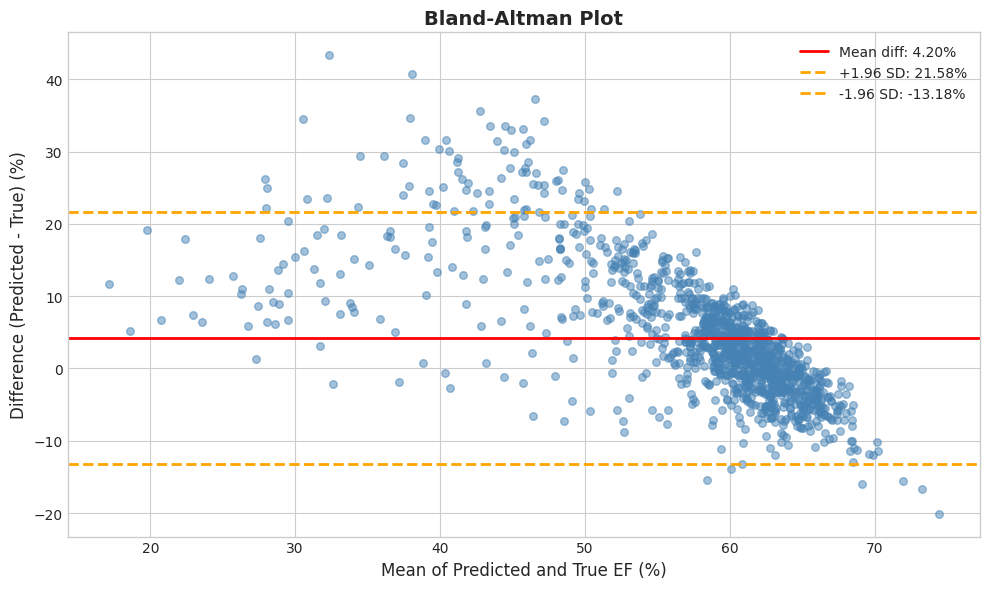

Bias (Mean Difference): 4.20%
Limits of Agreement: [-13.18%, 21.58%]


In [13]:
mean_ef = (predictions + true_values) / 2
diff_ef = predictions - true_values

mean_diff = np.mean(diff_ef)
std_diff = np.std(diff_ef)
upper_loa = mean_diff + 1.96 * std_diff
lower_loa = mean_diff - 1.96 * std_diff

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(mean_ef, diff_ef, alpha=0.5, s=30, c='steelblue')
ax.axhline(y=mean_diff, color='red', linestyle='-', linewidth=2, label=f'Mean diff: {mean_diff:.2f}%')
ax.axhline(y=upper_loa, color='orange', linestyle='--', linewidth=2, label=f'+1.96 SD: {upper_loa:.2f}%')
ax.axhline(y=lower_loa, color='orange', linestyle='--', linewidth=2, label=f'-1.96 SD: {lower_loa:.2f}%')
ax.set_xlabel('Mean of Predicted and True EF (%)', fontsize=12)
ax.set_ylabel('Difference (Predicted - True) (%)', fontsize=12)
ax.set_title('Bland-Altman Plot', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Bias (Mean Difference): {mean_diff:.2f}%")
print(f"Limits of Agreement: [{lower_loa:.2f}%, {upper_loa:.2f}%]")

## 10. Sample Predictions

In [14]:
results_df_sorted = results_df.sort_values('Error')

print("BEST PREDICTIONS (Lowest Error):")
print(results_df_sorted.head(10)[['FileName', 'True_EF', 'Pred_EF', 'Error', 'Category']].to_string())

print("\n" + "="*60)

print("\nWORST PREDICTIONS (Highest Error):")
print(results_df_sorted.tail(10)[['FileName', 'True_EF', 'Pred_EF', 'Error', 'Category']].to_string())

BEST PREDICTIONS (Lowest Error):
                FileName    True_EF    Pred_EF     Error Category
833   0X61606A54D357AD12  62.370842  62.372868  0.002025   Normal
542   0X45E3351DC2069AA3  62.406024  62.414974  0.008951   Normal
1263   0XDAC9597CA49DF0A  57.613468  57.626919  0.013451   Normal
1090  0X7846A393403DCE9A  64.815764  64.800446  0.015319   Normal
234   0X27C871612E887EF6  64.730408  64.764832  0.034424   Normal
1037   0X740F540B87B8AF3  64.744282  64.696930  0.047352   Normal
987   0X6F3E6EC0B32CBB66  62.590362  62.535767  0.054595   Normal
644   0X4F6EAF6EA9D0D4AA  62.544269  62.472809  0.071460   Normal
318   0X2ECE3ECC0BF62256  63.084763  63.164974  0.080211   Normal
1245   0XC3CC9222A4E69E6  61.177831  61.262589  0.084758   Normal


WORST PREDICTIONS (Highest Error):
                FileName    True_EF    Pred_EF      Error     Category
1159  0X7D567F2A870FD8F0  29.127013  62.320099  33.193086    Severe HF
748   0X5A8D9673920F03FE  26.654749  60.174522  33.519773    S

## 11. Summary

In [15]:
print("=" * 60)
print("MODEL EVALUATION SUMMARY")
print("=" * 60)
print(f"\nDataset: EchoNet-Dynamic")
print(f"Model: VideoMAE-base with Attention Pooling")
print(f"Test samples evaluated: {len(predictions)}")
print(f"\nOverall Metrics:")
print(f"  - MAE: {mae:.2f}%")
print(f"  - RMSE: {rmse:.2f}%")
print(f"  - R²: {r2:.3f}")
print(f"  - Correlation: {correlation:.3f}")
print(f"\nPer-Category MAE:")
for cat in category_order:
    cat_mae = bin_metrics.loc[cat, 'MAE']
    cat_n = int(bin_metrics.loc[cat, 'Count'])
    print(f"  - {cat}: {cat_mae:.2f}% (n={cat_n})")
print("=" * 60)

MODEL EVALUATION SUMMARY

Dataset: EchoNet-Dynamic
Model: VideoMAE-base with Attention Pooling
Test samples evaluated: 1277

Overall Metrics:
  - MAE: 6.93%
  - RMSE: 9.81%
  - R²: 0.356
  - Correlation: 0.712

Per-Category MAE:
  - Severe HF: 19.91% (n=83)
  - Moderate HF: 19.74% (n=77)
  - Mild/Borderline: 10.12% (n=241)
  - Normal: 3.45% (n=838)
  - Hyperdynamic: 9.30% (n=38)
